pip install torch torchaudio librosa numpy matplotlib


### Labeling 

In [20]:
import pandas as pd

# Path to the CSV file
csv_file_path1 = 'C:/Local Disc D/masters/Introduction to Deep Neural Netwoks/Final_Project/archive/Metadata_Train.csv'
csv_file_path2 = 'C:/Local Disc D/masters/Introduction to Deep Neural Netwoks/Final_Project/archive/Metadata_Test.csv'

# Load the CSV file into a DataFrame
df1 = pd.read_csv(csv_file_path1)
df2 = pd.read_csv(csv_file_path2)

# Function to convert sound names to numbers
def sound_to_number(sound):
    if sound == 'Sound_Guitar':
        return 0
    elif sound == 'Sound_Drum':
        return 1
    elif sound == 'Sound_Violin':
        return 2
    elif sound == 'Sound_Piano':
        return 3
    else:
        return None  # or a default value, if needed

# Apply the function to the second column and create a new third column
df1['New_Column'] = df1['Class'].apply(sound_to_number)
df2['New_Column'] = df2['Class'].apply(sound_to_number)

# Save the modified DataFrame back to a CSV file
df1.to_csv('C:/Local Disc D/masters/Introduction to Deep Neural Netwoks/Final_Project/archive/Updated_Metadata_Train.csv', index=False)
df2.to_csv('C:/Local Disc D/masters/Introduction to Deep Neural Netwoks/Final_Project/archive/Updated_Metadata_Test.csv', index=False)

# Optionally, print the DataFrame to see the result
print(df1)
print(df2)

                             FileName         Class  New_Column
0                   1-E1-Major 00.wav  Sound_Guitar           0
1                   1-E1-Major 01.wav  Sound_Guitar           0
2                   1-E1-Major 02.wav  Sound_Guitar           0
3                   1-E1-Major 03.wav  Sound_Guitar           0
4                   1-E1-Major 04.wav  Sound_Guitar           0
...                               ...           ...         ...
2624          strange-piano-73881.wav   Sound_Piano           3
2625        the-last-piano-112677.wav   Sound_Piano           3
2626  this-is-war-version-e-95411.wav   Sound_Piano           3
2627     tired-ghosts-piano-65013.wav   Sound_Piano           3
2628              toy-piano-27311.wav   Sound_Piano           3

[2629 rows x 3 columns]
                            FileName         Class  New_Column
0     acoustic-guitar-logo-13084.wav  Sound_Guitar           0
1            guitar-chords-70663.wav  Sound_Guitar           0
2            guita

### CNN Model Building 

#### Data Preprocessing 

In [12]:
import torch
from torch.utils.data import Dataset, DataLoader
import os
import torch
import torchaudio
import numpy as np
from torch.utils.data import Dataset, DataLoader
from torchvision.transforms import Compose
import librosa
import pandas as pd

class UrbanSoundDataset(Dataset):
    def __init__(self, annotations_file, audio_dir, transformation, target_sample_rate, num_samples, device):
        self.annotations = pd.read_csv(annotations_file)
        self.audio_dir = audio_dir
        self.device = device
        self.transformation = transformation.to(device)
        self.target_sample_rate = target_sample_rate
        self.num_samples = num_samples

    def __len__(self):
        return len(self.annotations)

#     def __getitem__(self, index):
#         audio_sample_path = self._get_audio_sample_path(index)
#         label = self._get_audio_sample_label(index)
#         signal, sr = librosa.load(audio_sample_path, sr=self.target_sample_rate)  # Load and resample the audio file
        
#         # Fix the audio signal length
#         if len(signal) > self.num_samples:
#             signal = signal[:self.num_samples]
#         elif len(signal) < self.num_samples:
#             padding = self.num_samples - len(signal)
#             signal = np.pad(signal, (0, padding), mode='constant')

#         # Apply transformation if any
#         if self.transformation:
#             signal = self.transformation(torch.tensor(signal).float().unsqueeze(0))

#         return signal, label
    
    def __getitem__(self, index):
        audio_sample_path = self._get_audio_sample_path(index)
        label = self._get_audio_sample_label(index)
        signal, sr = librosa.load(audio_sample_path, sr=self.target_sample_rate)  # Load and resample the audio file

        # Fix the audio signal length
        if len(signal) > self.num_samples:
            signal = signal[:self.num_samples]
        elif len(signal) < self.num_samples:
            padding = self.num_samples - len(signal)
            signal = np.pad(signal, (0, padding), mode='constant')

        # Convert signal to tensor
        signal = torch.tensor(signal, dtype=torch.float32).unsqueeze(0)  # Add channel dimension

        # Apply transformation if any
        if self.transformation:
            signal = self.transformation(signal)

        # Ensure label is a tensor
        label = torch.tensor(label, dtype=torch.int64)  # Ensure correct data type

        return signal.to(self.device), label.to(self.device)

    def _get_audio_sample_path(self, index):
        path = os.path.join(self.audio_dir, self.annotations.iloc[index, 0])
        return path

    def _get_audio_sample_label(self, index):
        return self.annotations.iloc[index, 2]
    
# Define transformation
mfcc_transform = torchaudio.transforms.MFCC(sample_rate=22050, n_mfcc=40, melkwargs={'n_fft': 2048, 'hop_length': 512, 'n_mels': 128})

# Create dataset and dataloader
dataset = UrbanSoundDataset(annotations_file='C:/Local Disc D/masters/Introduction to Deep Neural Netwoks/Final_Project/archive/Updated_Metadata_Train.csv',
                            audio_dir='C:/Local Disc D/masters/Introduction to Deep Neural Netwoks/Final_Project/archive/Train_submission/Train_submission/',
                            transformation=mfcc_transform,
                            target_sample_rate=22050,
                            num_samples=22050*4,  # 4 seconds worth of audio
                            device='cuda' if torch.cuda.is_available() else 'cpu')

data_loader = DataLoader(dataset, batch_size=32, shuffle=True)

for inputs, labels in data_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        print( labels)


tensor([0, 0, 1, 0, 2, 0, 0, 2, 0, 0, 2, 1, 3, 1, 0, 2, 3, 0, 2, 0, 1, 2, 3, 0,
        3, 3, 2, 2, 2, 0, 3, 2])
tensor([3, 0, 1, 3, 2, 1, 2, 1, 0, 2, 1, 2, 2, 1, 0, 1, 2, 1, 0, 2, 2, 2, 2, 3,
        3, 2, 2, 3, 2, 0, 2, 1])
tensor([0, 3, 0, 0, 2, 1, 1, 2, 2, 3, 0, 1, 2, 2, 2, 1, 3, 1, 1, 2, 2, 1, 1, 0,
        1, 1, 1, 3, 2, 1, 2, 2])
tensor([1, 2, 3, 2, 2, 1, 0, 0, 3, 2, 1, 0, 2, 1, 3, 2, 0, 3, 2, 0, 1, 0, 1, 0,
        0, 1, 0, 0, 0, 3, 2, 1])
tensor([0, 1, 3, 3, 3, 0, 2, 0, 2, 3, 3, 2, 1, 1, 1, 2, 1, 0, 3, 0, 0, 3, 0, 3,
        2, 3, 0, 0, 0, 0, 2, 3])
tensor([0, 2, 0, 0, 0, 2, 2, 1, 3, 2, 1, 2, 0, 0, 1, 1, 3, 0, 3, 3, 0, 3, 1, 1,
        0, 3, 3, 1, 1, 0, 2, 3])
tensor([3, 0, 2, 2, 1, 1, 3, 0, 1, 2, 1, 1, 1, 0, 3, 0, 3, 2, 2, 1, 2, 3, 3, 1,
        2, 2, 3, 2, 1, 0, 3, 0])
tensor([1, 2, 3, 2, 2, 2, 2, 2, 2, 3, 0, 1, 2, 2, 2, 1, 0, 1, 3, 2, 0, 2, 2, 0,
        0, 2, 1, 0, 1, 3, 0, 1])
tensor([1, 1, 0, 3, 0, 1, 0, 0, 3, 2, 1, 1, 0, 1, 2, 0, 3, 2, 1, 3, 1, 2, 1, 2,
        2, 2, 3,

KeyboardInterrupt: 

In [6]:
import torch
import torch.nn as nn
import torch.nn.functional as F

# Define the device to use: 'cuda' if a GPU with CUDA is available, otherwise 'cpu'
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

class AudioClassifier(nn.Module):   
    def __init__(self):
        super(AudioClassifier, self).__init__()
        self.conv1 = nn.Conv2d(1, 16, kernel_size=3, stride=1, padding=1)
        self.conv2 = nn.Conv2d(16, 32, kernel_size=3, stride=1, padding=1)
        self.conv3 = nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1)
        self.pool = nn.MaxPool2d(2, 2)
        self.flatten = nn.Flatten()
        self.fc1 = nn.Linear(6720, 128)  # Adjusted from 55360 to 6720
        self.fc2 = nn.Linear(128, 4)  # Assuming 4 classes (corrected from previous assumption of 10)
        self.dropout = nn.Dropout(0.5)
        
          

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = self.pool(F.relu(self.conv3(x)))
        x = self.flatten(x)
        x = F.relu(self.fc1(x))
        x = self.dropout(x)
        x = self.fc2(x)
        return x

# Initialize the model and move it to the selected device
model = AudioClassifier().to(device)


#### Training the model

Epoch 1, Loss: 1.1549581357513565, Accuracy: 0.600988969189806
Epoch 2, Loss: 0.5460119947611567, Accuracy: 0.6918980600988969
Epoch 3, Loss: 0.4662620769925864, Accuracy: 0.7101559528337771
Epoch 4, Loss: 0.44280717943806247, Accuracy: 0.7112970711297071
Epoch 5, Loss: 0.4264540029577462, Accuracy: 0.7177634081399772
Epoch 6, Loss: 0.4112619299845523, Accuracy: 0.7192848992012172
Epoch 7, Loss: 0.40377318338457363, Accuracy: 0.7219475085583872
Epoch 8, Loss: 0.40142921690481254, Accuracy: 0.7181437809052872
Epoch 9, Loss: 0.4017820695796645, Accuracy: 0.7329783187523773
Epoch 10, Loss: 0.3977416064365801, Accuracy: 0.7223278813236972


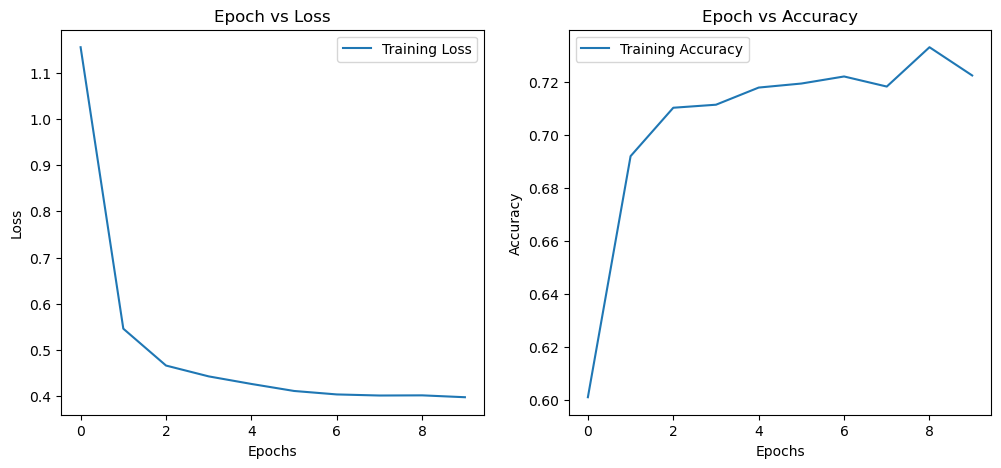

In [7]:
import torch.optim as optim
import matplotlib.pyplot as plt
# Define loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Training loop
num_epochs = 10




# Tracking loss and accuracy
train_loss = []
train_accuracy = []

for epoch in range(num_epochs):
    running_loss = 0.0
    correct_predictions = 0
    total_predictions = 0

    for inputs, labels in data_loader:
        inputs, labels = inputs.to(device), labels.to(device)

        optimizer.zero_grad()
        
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

        # Calculate accuracy
        _, predicted = torch.max(outputs, 1)
        correct_predictions += (predicted == labels).sum().item()
        total_predictions += labels.size(0)

    epoch_loss = running_loss / len(data_loader)
    epoch_accuracy = correct_predictions / total_predictions

    train_loss.append(epoch_loss)
    train_accuracy.append(epoch_accuracy)

    print(f"Epoch {epoch+1}, Loss: {epoch_loss}, Accuracy: {epoch_accuracy}")
    
import matplotlib.pyplot as plt
plt.figure(figsize=(12, 5))
num_epochs = 10
# Plotting loss
plt.subplot(1, 2, 1)
plt.plot(range(num_epochs), train_loss, label='Training Loss')
plt.title('Epoch vs Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

# Plotting accuracy
plt.subplot(1, 2, 2)
plt.plot(range(num_epochs), train_accuracy, label='Training Accuracy')
plt.title('Epoch vs Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.show()



#### Testing the Model 

In [23]:

import torch
from torch.utils.data import Dataset, DataLoader
import os
import torch
import torchaudio
import numpy as np
from torch.utils.data import Dataset, DataLoader
from torchvision.transforms import Compose
import librosa
import pandas as pd

class UrbanSoundDataset(Dataset):
    def __init__(self, annotations_file, audio_dir, transformation, target_sample_rate, num_samples, device):
        self.annotations = pd.read_csv(annotations_file)
        self.audio_dir = audio_dir
        self.device = device
        self.transformation = transformation.to(device)
        self.target_sample_rate = target_sample_rate
        self.num_samples = num_samples

    def __len__(self):
        return len(self.annotations)
    
    def __getitem__(self, index):
        audio_sample_path = self._get_audio_sample_path(index)
        label = self._get_audio_sample_label(index)
        signal, sr = librosa.load(audio_sample_path, sr=self.target_sample_rate)  # Load and resample the audio file

        # Fix the audio signal length
        if len(signal) > self.num_samples:
            signal = signal[:self.num_samples]
        elif len(signal) < self.num_samples:
            padding = self.num_samples - len(signal)
            signal = np.pad(signal, (0, padding), mode='constant')

        # Convert signal to tensor
        signal = torch.tensor(signal, dtype=torch.float32).unsqueeze(0)  # Add channel dimension

        # Apply transformation if any
        if self.transformation:
            signal = self.transformation(signal)

        # Ensure label is a tensor
        label = torch.tensor(label, dtype=torch.int64)  # Ensure correct data type

        return signal.to(self.device), label.to(self.device)

    def _get_audio_sample_path(self, index):
        path = os.path.join(self.audio_dir, self.annotations.iloc[index, 0])
        return path

    def _get_audio_sample_label(self, index):
        return self.annotations.iloc[index, 2]
    
# Define transformation
mfcc_transform = torchaudio.transforms.MFCC(sample_rate=22050, n_mfcc=40, melkwargs={'n_fft': 2048, 'hop_length': 512, 'n_mels': 128})

# Create dataset and dataloader
test_dataset = UrbanSoundDataset(annotations_file='C:/Local Disc D/masters/Introduction to Deep Neural Netwoks/Final_Project/archive/Updated_Metadata_test.csv',
                            audio_dir='C:/Local Disc D/masters/Introduction to Deep Neural Netwoks/Final_Project/archive/Test_submission/Test_submission/',
                            transformation=mfcc_transform,
                            target_sample_rate=22050,
                            num_samples=22050*4,  # 4 seconds worth of audio
                            device='cuda' if torch.cuda.is_available() else 'cpu')

test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

# Evaluate the model
model.eval()
total = 0
correct = 0
with torch.no_grad():
    for inputs, labels in test_loader:
        outputs = model(inputs)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

accuracy = correct / total
print(f"Test Accuracy: {accuracy * 100:.2f}%")


Test Accuracy: 63.75%


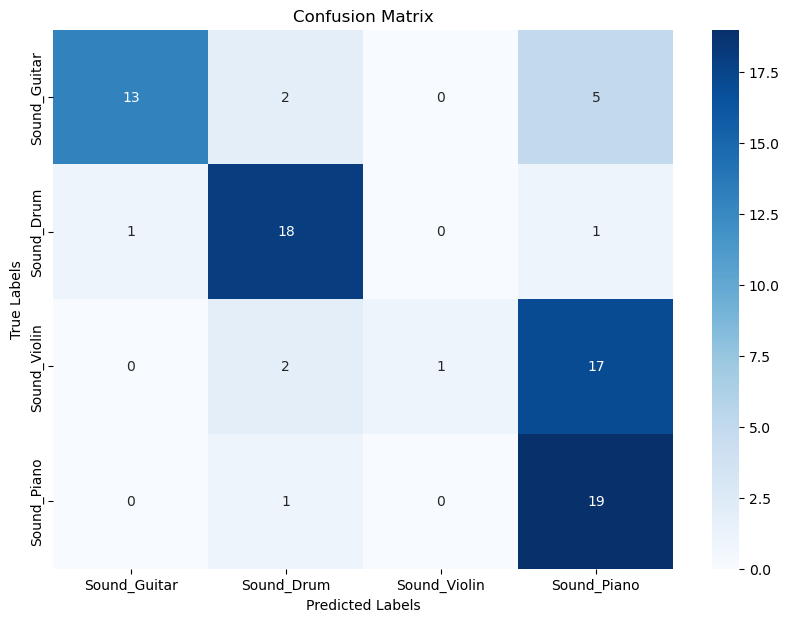

In [25]:
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
import seaborn as sns

# Initialize lists to gather predictions and true labels
y_pred = []
y_true = []

# Evaluate the model
model.eval()
with torch.no_grad():
    for inputs, labels in test_loader:
        outputs = model(inputs)
        _, predicted = torch.max(outputs.data, 1)
        y_pred.extend(predicted.cpu().numpy())  # Gather predictions
        y_true.extend(labels.cpu().numpy())  # Gather true labels

# Compute the confusion matrix
conf_matrix = confusion_matrix(y_true, y_pred)

class_names = ['Sound_Guitar' , 'Sound_Drum' , 'Sound_Violin' , 'Sound_Piano']

# Plotting the confusion matrix using seaborn
plt.figure(figsize=(10, 7))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()


### LSTM Model

#### Preprocessing for LSTM 

In [30]:
import torch
from torch.utils.data import Dataset, DataLoader
import os
import torch
import torchaudio
import numpy as np
from torch.utils.data import Dataset, DataLoader
from torchvision.transforms import Compose
import librosa
import pandas as pd

class UrbanSoundDataset(Dataset):
    def __init__(self, annotations_file, audio_dir, transformation, target_sample_rate, num_samples, device):
        self.annotations = pd.read_csv(annotations_file)
        self.audio_dir = audio_dir
        self.device = device
        self.transformation = transformation.to(device)
        self.target_sample_rate = target_sample_rate
        self.num_samples = num_samples

    def __len__(self):
        return len(self.annotations)
    
    def __getitem__(self, index):
        audio_sample_path = self._get_audio_sample_path(index)
        label = self._get_audio_sample_label(index)
        signal, sr = librosa.load(audio_sample_path, sr=self.target_sample_rate)  # Load and resample the audio file

        # Fix the audio signal length
        if len(signal) > self.num_samples:
            signal = signal[:self.num_samples]
        elif len(signal) < self.num_samples:
            padding = self.num_samples - len(signal)
            signal = np.pad(signal, (0, padding), mode='constant')

        # Apply transformation if any
        if self.transformation:
            signal = self.transformation(torch.tensor(signal).float().unsqueeze(0))

        # Reshape signal for LSTM input
        signal = signal.squeeze(0)  # Remove the channel dimension
#         signal = signal.view(1, -1, signal.size(0))  # Reshape to (batch_size=1, sequence_length, input_size)
        signal = signal.reshape(1, -1, signal.size(0))  # Reshape to (batch_size=1, sequence_length, input_size)

        # Ensure label is a tensor
        label = torch.tensor(label, dtype=torch.int64)  # Ensure correct data type

        return signal.to(self.device), label.to(self.device)


    def _get_audio_sample_path(self, index):
        path = os.path.join(self.audio_dir, self.annotations.iloc[index, 0])
        return path

    def _get_audio_sample_label(self, index):
        return self.annotations.iloc[index, 2]
    
# Define transformation
mfcc_transform = torchaudio.transforms.MFCC(sample_rate=22050, n_mfcc=40, melkwargs={'n_fft': 2048, 'hop_length': 512, 'n_mels': 128})

# Create dataset and dataloader
dataset = UrbanSoundDataset(annotations_file='C:/Local Disc D/masters/Introduction to Deep Neural Netwoks/Final_Project/archive/Updated_Metadata_Train.csv',
                            audio_dir='C:/Local Disc D/masters/Introduction to Deep Neural Netwoks/Final_Project/archive/Train_submission/Train_submission/',
                            transformation=mfcc_transform,
                            target_sample_rate=22050,
                            num_samples=22050*4,  # 4 seconds worth of audio
                            device='cuda' if torch.cuda.is_available() else 'cpu')

data_loader = DataLoader(dataset, batch_size=32, shuffle=True)

#### LSTM Model training 

Epoch 1, Loss: 0.8686, Accuracy: 62.91%
Epoch 2, Loss: 0.4978, Accuracy: 69.15%
Epoch 3, Loss: 0.4670, Accuracy: 70.22%
Epoch 4, Loss: 0.4397, Accuracy: 71.85%
Epoch 5, Loss: 0.4267, Accuracy: 70.29%
Epoch 6, Loss: 0.4238, Accuracy: 71.74%
Epoch 7, Loss: 0.4234, Accuracy: 72.08%
Epoch 8, Loss: 0.4101, Accuracy: 72.35%
Epoch 9, Loss: 0.4271, Accuracy: 71.17%
Epoch 10, Loss: 0.4140, Accuracy: 72.08%


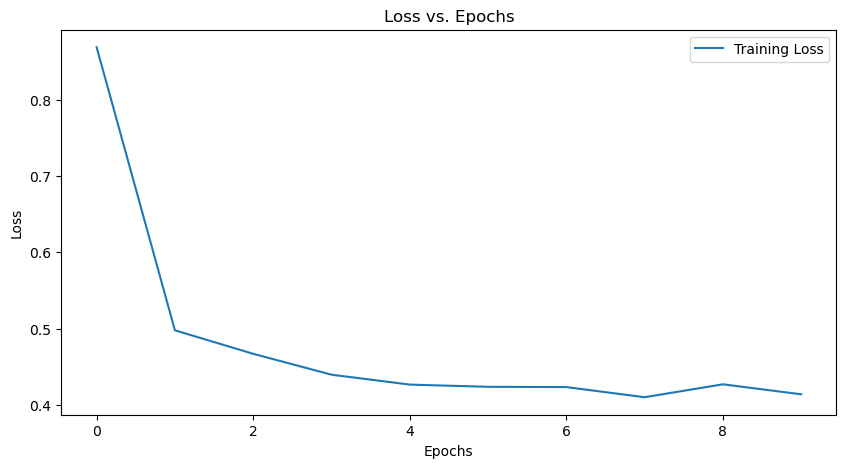

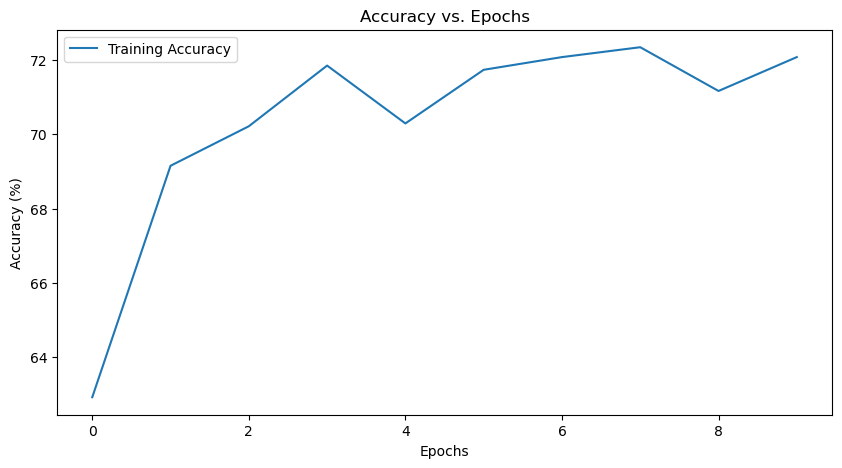

In [31]:
import torch
import torch.nn as nn

class AudioLSTM(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, num_classes):
        super(AudioLSTM, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_size, num_classes)

    def forward(self, x):
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(x.device) 
        c0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(x.device)
        
        out, _ = self.lstm(x, (h0, c0))
        out = self.fc(out[:, -1, :])
        return out

# Define model parameters
input_size = 173  # MFCC coefficients
hidden_size = 128
num_layers = 2
num_classes = 10  # Change this according to your number of classes

# Instantiate the model
model = AudioLSTM(input_size, hidden_size, num_layers, num_classes)

# Move model to device (CPU or GPU)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = model.to(device)

# Define loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

# Training loop
total_epochs = 10
# for epoch in range(total_epochs):
#     for i, (inputs, labels) in enumerate(data_loader):
#         inputs = inputs.to(device)
#         labels = labels.to(device)

#         # Forward pass
#         outputs = model(inputs)

#         # Calculate loss
#         loss = criterion(outputs, labels)

#         # Backward and optimize
#         optimizer.zero_grad()
#         loss.backward()
#         optimizer.step()

#         if (i+1) % 10 == 0:
#             print(f'Epoch [{epoch+1}/{total_epochs}], Step [{i+1}/{len(data_loader)}], Loss: {loss.item():.4f}')

# Training loop
# total_epochs = 10
# for epoch in range(total_epochs):
#     for i, (inputs, labels) in enumerate(data_loader):
#         inputs = inputs.squeeze(1)  # Remove channel dimension
#         inputs = inputs.permute(0, 2, 1)  # Permute dimensions to (batch_size, input_size, sequence_length)
#         inputs = inputs.to(device)
#         labels = labels.to(device)

#         # Forward pass
#         outputs = model(inputs)

#         # Calculate loss
#         loss = criterion(outputs, labels)

#         # Backward and optimize
#         optimizer.zero_grad()
#         loss.backward()
#         optimizer.step()

#     if (i+1) % 10 == 0:
#         print(f'Epoch [{epoch+1}/{total_epochs}], Step [{i+1}/{len(data_loader)}], Loss: {loss.item():.4f}')

train_losses = []
train_accuracies = []

total_epochs = 10
for epoch in range(total_epochs):
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0
    
    for i, (inputs, labels) in enumerate(data_loader):
        inputs = inputs.squeeze(1)  # Remove channel dimension
        inputs = inputs.permute(0, 2, 1)  # Permute dimensions to (batch_size, input_size, sequence_length)
        inputs, labels = inputs.to(device), labels.to(device)

        # Forward pass
        outputs = model(inputs)

        # Calculate loss
        loss = criterion(outputs, labels)
        running_loss += loss.item()

        # Backward and optimize
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        # Calculate accuracy
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
    
    epoch_loss = running_loss / len(data_loader)
    epoch_accuracy = 100 * correct / total

    train_losses.append(epoch_loss)
    train_accuracies.append(epoch_accuracy)

    print(f'Epoch {epoch+1}, Loss: {epoch_loss:.4f}, Accuracy: {epoch_accuracy:.2f}%')

# Plotting the loss over epochs
plt.figure(figsize=(10, 5))
plt.plot(train_losses, label='Training Loss')
plt.title('Loss vs. Epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

# Plotting the accuracy over epochs
plt.figure(figsize=(10, 5))
plt.plot(train_accuracies, label='Training Accuracy')
plt.title('Accuracy vs. Epochs')
plt.xlabel('Epochs')
plt.ylabel('Accuracy (%)')
plt.legend()
plt.show()


#### Model Testing 

In [32]:
import torch
from torch.utils.data import Dataset, DataLoader
import os
import torch
import torchaudio
import numpy as np
from torch.utils.data import Dataset, DataLoader
from torchvision.transforms import Compose
import librosa
import pandas as pd

class UrbanSoundDataset(Dataset):
    def __init__(self, annotations_file, audio_dir, transformation, target_sample_rate, num_samples, device):
        self.annotations = pd.read_csv(annotations_file)
        self.audio_dir = audio_dir
        self.device = device
        self.transformation = transformation.to(device)
        self.target_sample_rate = target_sample_rate
        self.num_samples = num_samples

    def __len__(self):
        return len(self.annotations)
    
    def __getitem__(self, index):
        audio_sample_path = self._get_audio_sample_path(index)
        label = self._get_audio_sample_label(index)
        signal, sr = librosa.load(audio_sample_path, sr=self.target_sample_rate)  # Load and resample the audio file

        # Fix the audio signal length
        if len(signal) > self.num_samples:
            signal = signal[:self.num_samples]
        elif len(signal) < self.num_samples:
            padding = self.num_samples - len(signal)
            signal = np.pad(signal, (0, padding), mode='constant')

        # Apply transformation if any
        if self.transformation:
            signal = self.transformation(torch.tensor(signal).float().unsqueeze(0))

        # Reshape signal for LSTM input
        signal = signal.squeeze(0)  # Remove the channel dimension
#         signal = signal.view(1, -1, signal.size(0))  # Reshape to (batch_size=1, sequence_length, input_size)
        signal = signal.reshape(1, -1, signal.size(0))  # Reshape to (batch_size=1, sequence_length, input_size)

        # Ensure label is a tensor
        label = torch.tensor(label, dtype=torch.int64)  # Ensure correct data type

        return signal.to(self.device), label.to(self.device)


    def _get_audio_sample_path(self, index):
        path = os.path.join(self.audio_dir, self.annotations.iloc[index, 0])
        return path

    def _get_audio_sample_label(self, index):
        return self.annotations.iloc[index, 2]
    
# Define transformation
mfcc_transform = torchaudio.transforms.MFCC(sample_rate=22050, n_mfcc=40, melkwargs={'n_fft': 2048, 'hop_length': 512, 'n_mels': 128})

# Create dataset and dataloader
test_dataset = UrbanSoundDataset(annotations_file='C:/Local Disc D/masters/Introduction to Deep Neural Netwoks/Final_Project/archive/Updated_Metadata_Test.csv',
                            audio_dir='C:/Local Disc D/masters/Introduction to Deep Neural Netwoks/Final_Project/archive/Test_submission/Test_submission/',
                            transformation=mfcc_transform,
                            target_sample_rate=22050,
                            num_samples=22050*4,  # 4 seconds worth of audio
                            device='cuda' if torch.cuda.is_available() else 'cpu')

test_data_loader = DataLoader(test_dataset, batch_size=32, shuffle=True)

Test Accuracy: 57.50%


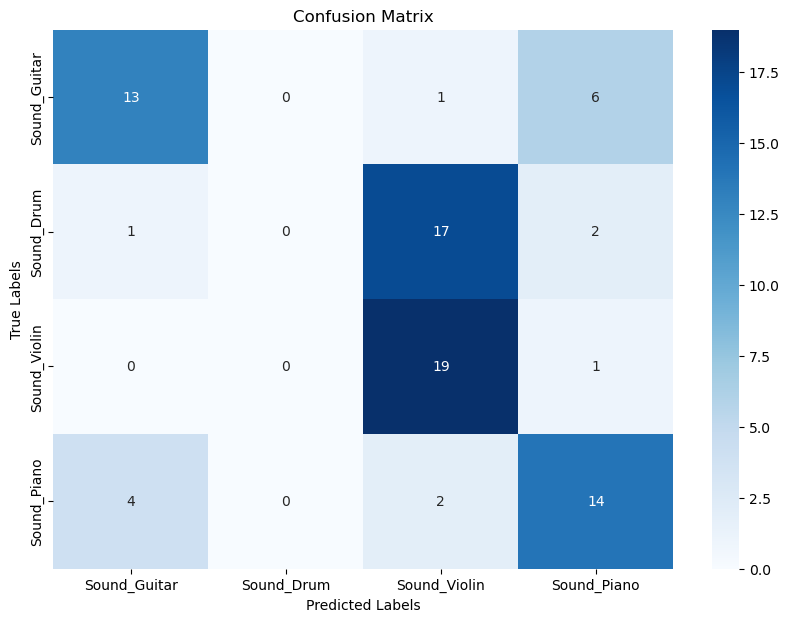

In [34]:
import torch
import torch.nn as nn
from sklearn.metrics import confusion_matrix, accuracy_score
import seaborn as sns
import matplotlib.pyplot as plt

# Assuming 'model' is already loaded and available
model.eval()  # Set the model to evaluation mode

# No gradient is needed for testing
with torch.no_grad():
    all_labels = []
    all_preds = []
    
    for inputs, labels in test_data_loader:
        inputs = inputs.squeeze(1)  # Adjust input dimensions if necessary
        inputs = inputs.permute(0, 2, 1)  # Adjust dimensions to (batch_size, input_size, sequence_length)
        outputs = model(inputs)
        _, predicted = torch.max(outputs, 1)
        
        all_labels.extend(labels.cpu().numpy())
        all_preds.extend(predicted.cpu().numpy())

# Calculate accuracy
accuracy = accuracy_score(all_labels, all_preds)
print(f"Test Accuracy: {accuracy * 100:.2f}%")

# Compute confusion matrix
conf_matrix = confusion_matrix(all_labels, all_preds)

# # Plotting confusion matrix
# plt.figure(figsize=(10, 8))
# sns.heatmap(conf_matrix, annot=True, fmt="d", cmap='Blues')
# plt.xlabel('Predicted Label')
# plt.ylabel('True Label')
# plt.title('Confusion Matrix')
# plt.show()

class_names = ['Sound_Guitar' , 'Sound_Drum' , 'Sound_Violin' , 'Sound_Piano']

# Plotting the confusion matrix using seaborn
plt.figure(figsize=(10, 7))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()



### Transfer learning using Resnet18 as pretrained model

#### Preprocessing of audio data for pretrained model 

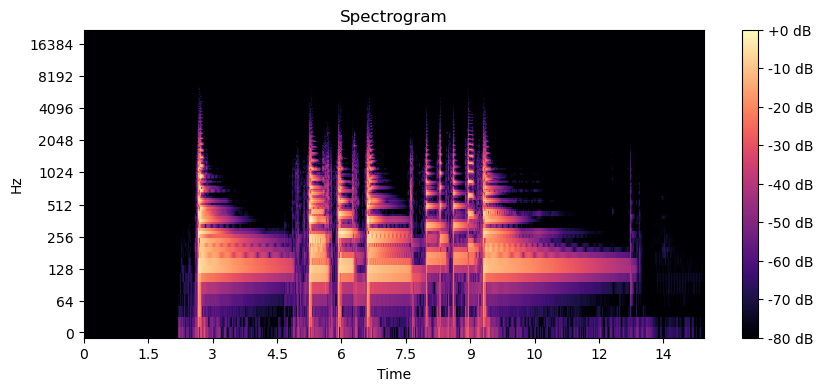

In [5]:
import librosa
import librosa.display
import matplotlib.pyplot as plt
import numpy as np

# import librosa
# import librosa.display
# import matplotlib.pyplot as plt
# import numpy as np
# import torch
# import torch.nn as nn
# from torchvision import models
# from torch.utils.data import DataLoader, Dataset
# from torchvision.transforms import transforms

def audio_to_spectrogram(audio_path, hop_length=512, n_fft=2048):
    y, sr = librosa.load(audio_path, sr=None)
    S = librosa.stft(y, n_fft=n_fft, hop_length=hop_length)
    D = librosa.amplitude_to_db(abs(S), ref=np.max)
    return D,sr

# Example of plotting a spectrogram
audio_path = 'C:/Local Disc D/masters/Introduction to Deep Neural Netwoks/Final_Project/archive/Train_submission/Train_submission/AR_Lick9_MN.wav'
spectrogram,sr = audio_to_spectrogram(audio_path)
plt.figure(figsize=(10, 4))
librosa.display.specshow(spectrogram, sr=sr, x_axis='time', y_axis='log')
plt.colorbar(format='%+2.0f dB')
plt.title('Spectrogram')
plt.show()

In [6]:
import pandas as pd
import os

# Path to the CSV file that contains the names of the .wav files
csv_file_path = r'C:\Local Disc D\masters\Introduction to Deep Neural Netwoks\Final_Project\archive\Updated_Metadata_Train.csv'

# Directory where the .wav files are stored
directory_path = 'C:/Local Disc D/masters/Introduction to Deep Neural Netwoks/Final_Project/archive/Train_submission/Train_submission'

# Read the CSV file
df = pd.read_csv(csv_file_path)

# Assume the column containing the .wav file names is named 'filename'
# Update 'filename' to the actual column name if different
wav_filenames = df['FileName'].tolist()

labels =  df['New_Column'].tolist()

# Create full paths by concatenating the directory path with each filename
wav_file_paths = [os.path.join(directory_path, filename) for filename in wav_filenames]

# Print the list of file paths
for path in wav_file_paths:
    print(path)
for label in labels:
    print(label)

C:/Local Disc D/masters/Introduction to Deep Neural Netwoks/Final_Project/archive/Train_submission/Train_submission\1-E1-Major 00.wav
C:/Local Disc D/masters/Introduction to Deep Neural Netwoks/Final_Project/archive/Train_submission/Train_submission\1-E1-Major 01.wav
C:/Local Disc D/masters/Introduction to Deep Neural Netwoks/Final_Project/archive/Train_submission/Train_submission\1-E1-Major 02.wav
C:/Local Disc D/masters/Introduction to Deep Neural Netwoks/Final_Project/archive/Train_submission/Train_submission\1-E1-Major 03.wav
C:/Local Disc D/masters/Introduction to Deep Neural Netwoks/Final_Project/archive/Train_submission/Train_submission\1-E1-Major 04.wav
C:/Local Disc D/masters/Introduction to Deep Neural Netwoks/Final_Project/archive/Train_submission/Train_submission\1-E1-Major 05.wav
C:/Local Disc D/masters/Introduction to Deep Neural Netwoks/Final_Project/archive/Train_submission/Train_submission\1-E1-Major 06.wav
C:/Local Disc D/masters/Introduction to Deep Neural Netwoks/Fi

#### Training the model

In [ ]:
import torch
from torch import nn
from torch.utils.data import DataLoader, Dataset
import torchvision.transforms as transforms
from torchvision import models
import numpy as np

import torch
from torch import nn
from torch.utils.data import DataLoader, Dataset
import torchvision.transforms as transforms
from torchvision import models
import librosa
import librosa.display
import matplotlib.pyplot as plt
import numpy as np
import os
import librosa
import librosa.display
import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.nn as nn
from torchvision import models
from torch.utils.data import DataLoader, Dataset
from torchvision.transforms import transforms

# Assuming audio_to_spectrogram is defined elsewhere and works correctly

# class AudioDataset(Dataset):
#     def __init__(self, audio_paths, labels, max_length=512):  # Adjust max_length based on your actual needs
#         self.audio_paths = [self.correct_path(path) for path in audio_paths]
#         self.labels = labels
#         self.max_length = max_length
#         self.transform = transforms.Compose([
#             transforms.ToTensor(),
#             transforms.Normalize(mean=[0.485], std=[0.229])
#         ])

#     def __len__(self):
#         return len(self.audio_paths)
    
#     def __getitem__(self, idx):
#         audio_path = self.audio_paths[idx]
#         label = self.labels[idx]
#         spectrogram, sr = audio_to_spectrogram(audio_path)
#         # Normalize and resize the spectrogram to fit the model input
#         spectrogram = resize_spectrogram(spectrogram, self.max_length)
#         spectrogram = self.transform(spectrogram)
#         return spectrogram, label

#     @staticmethod
#     def correct_path(path):
#         return path.replace("\\", "/")

#     @staticmethod
#     def resize_spectrogram(spectrogram, max_length):
#         # Resize spectrogram to (1, 224, 224) for ResNet or other required size
#         if spectrogram.shape[1] < max_length:
#             padding = max_length - spectrogram.shape[1]
#             spectrogram = np.pad(spectrogram, ((0, 0), (0, padding)), mode='constant')
#         elif spectrogram.shape[1] > max_length:
#             spectrogram = spectrogram[:, :max_length]
#         return spectrogram

class AudioDataset(Dataset):
    def __init__(self, audio_paths, labels, max_length=512):
        self.audio_paths = [self.correct_path(path) for path in audio_paths]
        self.labels = labels
        self.max_length = max_length
        self.transform = transforms.Compose([
            transforms.ToTensor(),
            transforms.Normalize(mean=[0.485], std=[0.229])
        ])

    def __len__(self):
        return len(self.audio_paths)
    
    def __getitem__(self, idx):
        audio_path = self.audio_paths[idx]
        label = self.labels[idx]
        spectrogram, sr = audio_to_spectrogram(audio_path)
        spectrogram = self.resize_spectrogram(spectrogram, self.max_length)  # Using self.resize_spectrogram
        spectrogram = self.transform(spectrogram)
        return spectrogram, label

    @staticmethod
    def correct_path(path):
        return path.replace("\\", "/")

    @staticmethod
    def resize_spectrogram(spectrogram, max_length):
        # Define the resizing logic here
        if spectrogram.shape[1] < max_length:
            padding = max_length - spectrogram.shape[1]
            spectrogram = np.pad(spectrogram, ((0, 0), (0, padding)), mode='constant')
        elif spectrogram.shape[1] > max_length:
            spectrogram = spectrogram[:, :max_length]
        return spectrogram


# Load pre-trained ResNet model
model = models.resnet18(pretrained=True)
model.conv1 = nn.Conv2d(1, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
num_features = model.fc.in_features
model.fc = nn.Linear(num_features, 4)  # Adjust number of classes

# Example usage
audio_paths = wav_file_paths # Add paths # Example labels corresponding to the paths


labels =  df['New_Column'].tolist()
dataset = AudioDataset(audio_paths, labels)
loader = DataLoader(dataset, batch_size=10, shuffle=True)  # Reduced batch size

optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
criterion = nn.CrossEntropyLoss()

# Training loop (simplified)
num_epochs = 10
import torch
from torch import nn
from torch.utils.data import DataLoader, Dataset
import torchvision.transforms as transforms
from torchvision import models
import numpy as np
import matplotlib.pyplot as plt

# Assuming the training loop and dataset are defined as before

# Training loop
num_epochs = 10
train_losses = []
train_accuracies = []

for epoch in range(num_epochs):
    epoch_loss = 0.0
    correct = 0
    total = 0

    for inputs, targets in loader:
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, targets)
        loss.backward()
        optimizer.step()

        # Calculate accuracy
        _, predicted = torch.max(outputs.data, 1)
        total += targets.size(0)
        correct += (predicted == targets).sum().item()

        epoch_loss += loss.item()

    # Calculate accuracy and loss for the epoch
    epoch_loss /= len(loader)
    epoch_accuracy = correct / total

    train_losses.append(epoch_loss)
    train_accuracies.append(epoch_accuracy)

    print(f"Epoch {epoch+1}, Loss: {epoch_loss}, Accuracy: {epoch_accuracy}")

# Plotting loss vs epochs
plt.plot(range(1, num_epochs+1), train_losses, label='Training Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Loss vs Epochs')
plt.legend()
plt.show()

# Plotting accuracy vs epochs
plt.plot(range(1, num_epochs+1), train_accuracies, label='Training Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Accuracy vs Epochs')
plt.legend()
plt.show()



C:\Users\majji\AppData\Roaming\Python\Python311\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
C:\Users\majji\AppData\Roaming\Python\Python311\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Epoch 1, Loss: 0.7181428679381939, Accuracy: 0.6531000380372766
Epoch 2, Loss: 0.6039808978655946, Accuracy: 0.6759224039558768


### Testing the model

In [4]:
import pandas as pd
import os

# Path to the CSV file that contains the names of the .wav files
csv_file_path = r'C:\Local Disc D\masters\Introduction to Deep Neural Netwoks\Final_Project\archive\Updated_Metadata_Test.csv'

# Directory where the .wav files are stored
directory_path = 'C:/Local Disc D/masters/Introduction to Deep Neural Netwoks/Final_Project/archive/Test_submission/Test_submission'

# Read the CSV file
df = pd.read_csv(csv_file_path)

# Assume the column containing the .wav file names is named 'filename'
# Update 'filename' to the actual column name if different
wav_filenames = df['FileName'].tolist()

labels =  df['New_Column'].tolist()

# Create full paths by concatenating the directory path with each filename
wav_file_paths = [os.path.join(directory_path, filename) for filename in wav_filenames]

# Print the list of file paths

In [ ]:
import torch
from torch import nn
from torch.utils.data import DataLoader, Dataset
import torchvision.transforms as transforms
from torchvision import models
import numpy as np

import torch
from torch import nn
from torch.utils.data import DataLoader, Dataset
import torchvision.transforms as transforms
from torchvision import models
import librosa
import librosa.display
import matplotlib.pyplot as plt
import numpy as np
import os
import librosa
import librosa.display
import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.nn as nn
from torchvision import models
from torch.utils.data import DataLoader, Dataset
from torchvision.transforms import transforms

# Assuming audio_to_spectrogram is defined elsewhere and works correctly

# class AudioDataset(Dataset):
#     def __init__(self, audio_paths, labels, max_length=512):  # Adjust max_length based on your actual needs
#         self.audio_paths = [self.correct_path(path) for path in audio_paths]
#         self.labels = labels
#         self.max_length = max_length
#         self.transform = transforms.Compose([
#             transforms.ToTensor(),
#             transforms.Normalize(mean=[0.485], std=[0.229])
#         ])

#     def __len__(self):
#         return len(self.audio_paths)
    
#     def __getitem__(self, idx):
#         audio_path = self.audio_paths[idx]
#         label = self.labels[idx]
#         spectrogram, sr = audio_to_spectrogram(audio_path)
#         # Normalize and resize the spectrogram to fit the model input
#         spectrogram = resize_spectrogram(spectrogram, self.max_length)
#         spectrogram = self.transform(spectrogram)
#         return spectrogram, label

#     @staticmethod
#     def correct_path(path):
#         return path.replace("\\", "/")

#     @staticmethod
#     def resize_spectrogram(spectrogram, max_length):
#         # Resize spectrogram to (1, 224, 224) for ResNet or other required size
#         if spectrogram.shape[1] < max_length:
#             padding = max_length - spectrogram.shape[1]
#             spectrogram = np.pad(spectrogram, ((0, 0), (0, padding)), mode='constant')
#         elif spectrogram.shape[1] > max_length:
#             spectrogram = spectrogram[:, :max_length]
#         return spectrogram

class AudioDataset(Dataset):
    def __init__(self, audio_paths, labels, max_length=512):
        self.audio_paths = [self.correct_path(path) for path in audio_paths]
        self.labels = labels
        self.max_length = max_length
        self.transform = transforms.Compose([
            transforms.ToTensor(),
            transforms.Normalize(mean=[0.485], std=[0.229])
        ])

    def __len__(self):
        return len(self.audio_paths)
    
    def __getitem__(self, idx):
        audio_path = self.audio_paths[idx]
        label = self.labels[idx]
        spectrogram, sr = audio_to_spectrogram(audio_path)
        spectrogram = self.resize_spectrogram(spectrogram, self.max_length)  # Using self.resize_spectrogram
        spectrogram = self.transform(spectrogram)
        return spectrogram, label

    @staticmethod
    def correct_path(path):
        return path.replace("\\", "/")

    @staticmethod
    def resize_spectrogram(spectrogram, max_length):
        # Define the resizing logic here
        if spectrogram.shape[1] < max_length:
            padding = max_length - spectrogram.shape[1]
            spectrogram = np.pad(spectrogram, ((0, 0), (0, padding)), mode='constant')
        elif spectrogram.shape[1] > max_length:
            spectrogram = spectrogram[:, :max_length]
        return spectrogram


# Load pre-trained ResNet model
model = models.resnet18(pretrained=True)
model.conv1 = nn.Conv2d(1, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
num_features = model.fc.in_features
model.fc = nn.Linear(num_features, 4)  # Adjust number of classes

# Example usage
audio_paths = wav_file_paths # Add paths # Example labels corresponding to the paths


labels =  df['New_Column'].tolist()
test_dataset = AudioDataset(audio_paths, labels)
test_loader = DataLoader(test_dataset, batch_size=10, shuffle=True)  # Reduced batch size

In [ ]:
import torch
from sklearn.metrics import confusion_matrix, accuracy_score
import seaborn as sns
import matplotlib.pyplot as plt

# Ensure model is in evaluation mode
model.eval()

# Move model to the appropriate device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

# Variables to hold predictions and actual labels
all_preds = []
all_labels = []

# Disable gradient computation for evaluation (reduces memory usage and speeds up computation)
with torch.no_grad():
    for data in test_loader:
        inputs, labels = data
        inputs, labels = inputs.to(device), labels.to(device)

        # Forward pass
        outputs = model(inputs)
        _, predicted = torch.max(outputs.data, 1)
        
        # Collect all predictions and labels
        all_preds.extend(predicted.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

# Calculate accuracy
accuracy = accuracy_score(all_labels, all_preds)
print(f'Accuracy: {accuracy * 100:.2f}%')

# Compute confusion matrix
conf_matrix = confusion_matrix(all_labels, all_preds)

# Plot confusion matrix
plt.figure(figsize=(10, 7))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=['Class 1', 'Class 2', 'Class 3', 'Class 4'], yticklabels=['Class 1', 'Class 2', 'Class 3', 'Class 4'])
plt.title('Confusion Matrix')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.show()


### Support vector machines 

In [42]:
import torch
from torch.utils.data import DataLoader, Dataset
from sklearn import svm
from sklearn.preprocessing import StandardScaler
import numpy as np
import librosa

# Define a dataset class for audio data
class AudioDataset(Dataset):
    def __init__(self, audio_paths, labels):
        self.audio_paths = audio_paths
        self.labels = labels

    def __len__(self):
        return len(self.audio_paths)

    def __getitem__(self, idx):
        audio_path = self.audio_paths[idx]
        label = self.labels[idx]
        audio, sr = librosa.load(audio_path, sr=None)
        return audio, label

# Function to extract features from audio files
def extract_features(audio, max_pad_len=174):
    mfccs = librosa.feature.mfcc(y=audio, sr=16000, n_mfcc=40)
    pad_width = max_pad_len - mfccs.shape[1]
    if pad_width < 0:
        mfccs = mfccs[:, :max_pad_len]  # Truncate the excess columns
    else:
        mfccs = np.pad(mfccs, pad_width=((0, 0), (0, pad_width)), mode='constant')
    return mfccs.flatten()

# Function to preprocess the data
def preprocess_data(audio_paths, labels):
    features = []
    for path in audio_paths:
        audio, _ = librosa.load(path, sr=16000)
        features.append(extract_features(audio))
    X = np.array(features)
    y = np.array(labels)
    return X, y

import pandas as pd
import os

# Path to the CSV file that contains the names of the .wav files
csv_file_path = r'C:\Local Disc D\masters\Introduction to Deep Neural Netwoks\Final_Project\archive\Updated_Metadata_Train.csv'

# Directory where the .wav files are stored
directory_path = 'C:/Local Disc D/masters/Introduction to Deep Neural Netwoks/Final_Project/archive/Train_submission/Train_submission'

# Read the CSV file
df = pd.read_csv(csv_file_path)

# Assume the column containing the .wav file names is named 'filename'
# Update 'filename' to the actual column name if different
wav_filenames = df['FileName'].tolist()

labels =  df['New_Column'].tolist()

# Create full paths by concatenating the directory path with each filename
wav_file_paths = [os.path.join(directory_path, filename) for filename in wav_filenames]

audio_paths = wav_file_paths # Add paths # Example labels corresponding to the paths
labels =  df['New_Column'].tolist()

# Preprocess the data
X, y = preprocess_data(audio_paths, labels)

# Standardize features by removing the mean and scaling to unit variance
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Convert NumPy arrays to PyTorch tensors
X_tensor = torch.tensor(X_scaled, dtype=torch.float32)
y_tensor = torch.tensor(y, dtype=torch.long)

# Train the SVM model
svm_model = svm.SVC(kernel='linear')
svm_model.fit(X_tensor, y_tensor)


SVC(kernel='linear')

#### Testing the model

Test Accuracy: 45.00%


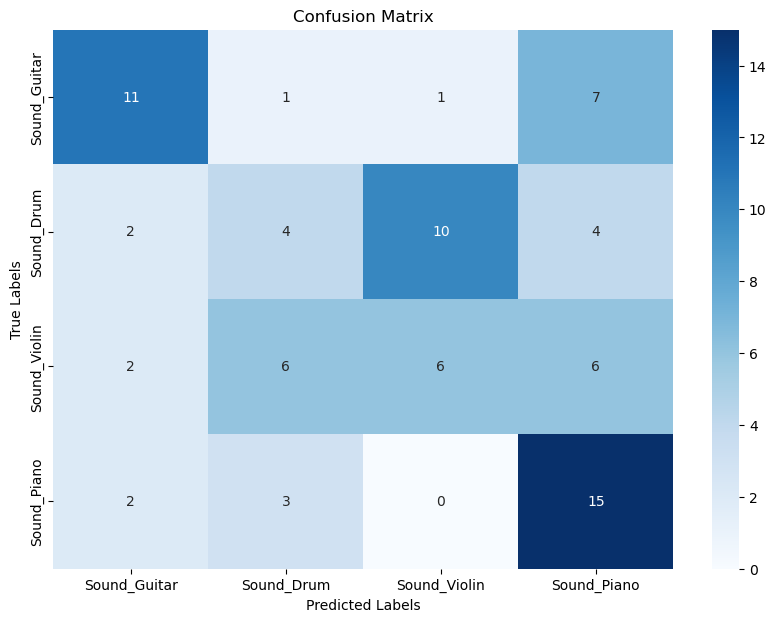

In [45]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score

# Define a dataset class for test audio data
class TestAudioDataset(Dataset):
    def __init__(self, audio_paths):
        self.audio_paths = audio_paths

    def __len__(self):
        return len(self.audio_paths)

    def __getitem__(self, idx):
        audio_path = self.audio_paths[idx]
        audio, sr = librosa.load(audio_path, sr=16000)
        return audio

# Function to preprocess test data
def preprocess_test_data(audio_paths):
    test_features = []
    for path in audio_paths:
        audio, _ = librosa.load(path, sr=16000)
        test_features.append(extract_features(audio))
    X_test = np.array(test_features)
    X_test_scaled = scaler.transform(X_test)
    return torch.tensor(X_test_scaled, dtype=torch.float32)

# Path to the CSV file containing test file names and labels
test_csv_file_path = r'C:\Local Disc D\masters\Introduction to Deep Neural Netwoks\Final_Project\archive\Updated_Metadata_Test.csv'

# Read the CSV file
test_df = pd.read_csv(test_csv_file_path)

# Extract test file names and labels
test_wav_filenames = test_df['FileName'].tolist()
test_labels = test_df['New_Column'].tolist()

# Create full paths for test audio files
test_wav_file_paths = [os.path.join('C:/Local Disc D/masters/Introduction to Deep Neural Netwoks/Final_Project/archive/Test_submission/Test_submission/', filename) for filename in test_wav_filenames]

# Create dataset for test data
test_dataset = TestAudioDataset(test_wav_file_paths)

# Extract features and preprocess test data
X_test_tensor = preprocess_test_data(test_wav_file_paths)

# Make predictions using the trained SVM model
predictions = svm_model.predict(X_test_tensor)

accuracy = accuracy_score(test_labels, predictions)
print(f'Test Accuracy: {accuracy * 100:.2f}%')

# Generate confusion matrix
cm = confusion_matrix(test_labels, predictions)


# # Plot confusion matrix
# plt.figure(figsize=(10, 8))
# sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=labels, yticklabels=labels)
# plt.xlabel('Predicted Label')
# plt.ylabel('True Label')
# plt.title('Confusion Matrix')
# plt.show()

class_names = ['Sound_Guitar' , 'Sound_Drum' , 'Sound_Violin' , 'Sound_Piano']

# Plotting the confusion matrix using seaborn
plt.figure(figsize=(10, 7))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()


### Transformers model

In [3]:
import torch
import torch.nn as nn
import torchaudio
from torch.utils.data import DataLoader, Dataset
from sklearn.model_selection import train_test_split
import numpy as np



class AudioDataset(Dataset):
    def __init__(self, audio_paths, labels, transform=None, target_length=16000, output_features=128):
        self.audio_paths = audio_paths
        self.labels = labels
        self.transform = transform
        self.target_length = target_length
        self.output_features = output_features  # This aligns with d_model in transformer

    def __len__(self):
        return len(self.audio_paths)

    def __getitem__(self, idx):
        audio_path = self.audio_paths[idx]
        label = self.labels[idx]
        waveform, sr = torchaudio.load(audio_path)

        if waveform.shape[0] > 1:
            waveform = torch.mean(waveform, dim=0, keepdim=True)

        if self.transform:
            waveform = self.transform(waveform)

        if waveform.size(-1) < self.target_length:
            padding_size = self.target_length - waveform.size(-1)
            waveform = nn.functional.pad(waveform, (0, padding_size))
        elif waveform.size(-1) > self.target_length:
            waveform = waveform[:, :, :self.target_length]

        # Reshape or process waveform to ensure it matches the [sequence_length, batch_size, d_model]
        waveform = waveform.transpose(1, 2)  # Swap frequency and time axis
        if waveform.size(1) != self.output_features:
            waveform = nn.functional.interpolate(waveform, size=self.output_features, mode='linear', align_corners=False)

#         return waveform.squeeze(0), label
        # Modify dataset class to ensure targets are tensors and correctly shaped
        return waveform.squeeze(0), torch.tensor(label).long()  # Ensure labels are long type tensors

# Define the transformer model
class AudioTransformer(nn.Module):
    def __init__(self, num_classes=10, d_model=128, nhead=8, num_encoder_layers=3, dim_feedforward=256, dropout=0.1):
        super(AudioTransformer, self).__init__()
        self.transformer = nn.Transformer(d_model=d_model, nhead=nhead, num_encoder_layers=num_encoder_layers, dim_feedforward=dim_feedforward, dropout=dropout)
        self.fc_out = nn.Linear(d_model, num_classes)
        self.pos_encoder = PositionalEncoding(d_model, dropout)

    def forward(self, src):
        src = self.pos_encoder(src)
        output = self.transformer(src, src)
        output = output.mean(dim=1)  # Pooling the output of the transformer
        output = self.fc_out(output)
        return output

# Positional Encoding
class PositionalEncoding(nn.Module):
    def __init__(self, d_model, dropout=0.1, max_len=5000):
        super(PositionalEncoding, self).__init__()
        self.dropout = nn.Dropout(p=dropout)

        position = torch.arange(max_len).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, d_model, 2) * -(np.log(10000.0) / d_model))
        pe = torch.zeros(max_len, 1, d_model)
        pe[:, 0, 0::2] = torch.sin(position * div_term)
        pe[:, 0, 1::2] = torch.cos(position * div_term)
        self.register_buffer('pe', pe)

    def forward(self, x):
        x = x + self.pe[:x.size(0)]
        return self.dropout(x)

# Set device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Example usage
audio_paths = wav_file_paths # Add paths # Example labels corresponding to the paths
labels =  df['New_Column'].tolist()


transform = torchaudio.transforms.MelSpectrogram(sample_rate=16000, n_fft=400, hop_length=160, n_mels=64)
target_length = 2 # This should be set according to your data and needs
dataset = AudioDataset(audio_paths, labels, transform=transform, target_length=target_length)
dataloader = DataLoader(dataset, batch_size=2, shuffle=True)


model = AudioTransformer(num_classes=10).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)





C:\Users\majji\AppData\Roaming\Python\Python311\site-packages\torch\nn\modules\transformer.py:282: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(f"enable_nested_tensor is True, but self.use_nested_tensor is False because {why_not_sparsity_fast_path}")


Epoch 1, Loss: 1.668717274069786, Accuracy: 0.1875
Epoch 2, Loss: 1.4815302729606628, Accuracy: 0.2125
Epoch 3, Loss: 1.4889251485466957, Accuracy: 0.225
Epoch 4, Loss: 1.4836875081062317, Accuracy: 0.1625
Epoch 5, Loss: 1.4650501042604447, Accuracy: 0.225
Epoch 6, Loss: 1.416889378428459, Accuracy: 0.225
Epoch 7, Loss: 1.4376796156167984, Accuracy: 0.2375
Epoch 8, Loss: 1.4847926527261734, Accuracy: 0.175
Epoch 9, Loss: 1.4184525281190872, Accuracy: 0.2375
Epoch 10, Loss: 1.4143991440534591, Accuracy: 0.3
Epoch 11, Loss: 1.4276714891195297, Accuracy: 0.25
Epoch 12, Loss: 1.429054781794548, Accuracy: 0.225
Epoch 13, Loss: 1.4288999348878861, Accuracy: 0.2125
Epoch 14, Loss: 1.4518466979265212, Accuracy: 0.125
Epoch 15, Loss: 1.492097121477127, Accuracy: 0.175
Epoch 16, Loss: 1.4426844745874405, Accuracy: 0.1875
Epoch 17, Loss: 1.421326044201851, Accuracy: 0.175
Epoch 18, Loss: 1.4151625424623488, Accuracy: 0.2375
Epoch 19, Loss: 1.4220251441001892, Accuracy: 0.2
Epoch 20, Loss: 1.42751

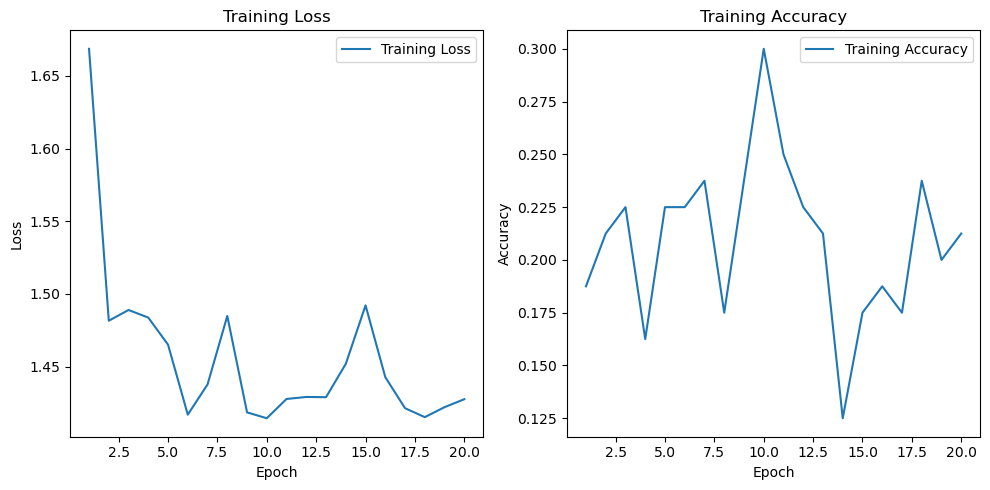

In [4]:
import matplotlib.pyplot as plt

# Initialize lists to store loss and accuracy values
loss_values = []
accuracy_values = []

model.train()

for epoch in range(20):
    total_loss = 0.0
    correct_predictions = 0
    total_predictions = 0
    
    for inputs, targets in dataloader:
        inputs = inputs.to(device)  # [batch_size, sequence_length, d_model]
        inputs = inputs.permute(1, 0, 2)  # Permute to [sequence_length, batch_size, d_model]
        targets = targets.to(device)

        if targets.size(0) == 1:  # Skip batches with target size 1
            continue

        optimizer.zero_grad()
        outputs = model(inputs)

        # Filter out outputs and targets with batch size 1

        loss = criterion(outputs, targets)
        total_loss += loss.item()
        loss.backward()
        optimizer.step()

        # Calculate accuracy
        _, predicted = torch.max(outputs, 1)
        correct_predictions += (predicted == targets).sum().item()
        total_predictions += targets.size(0)

    epoch_loss = total_loss / len(dataloader)
    epoch_accuracy = correct_predictions / total_predictions

    loss_values.append(epoch_loss)
    accuracy_values.append(epoch_accuracy)

    print(f'Epoch {epoch+1}, Loss: {epoch_loss}, Accuracy: {epoch_accuracy}')

# Plotting the loss and accuracy
plt.figure(figsize=(10, 5))

plt.subplot(1, 2, 1)
plt.plot(range(1, len(loss_values) + 1), loss_values, label='Training Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(range(1, len(accuracy_values) + 1), accuracy_values, label='Training Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Training Accuracy')
plt.legend()

plt.tight_layout()
plt.show()


#### Testing the Model 

In [5]:
import pandas as pd
import os

# Path to the CSV file that contains the names of the .wav files
csv_file_path = r'C:\Local Disc D\masters\Introduction to Deep Neural Netwoks\Final_Project\archive\Updated_Metadata_Test.csv'

# Directory where the .wav files are stored
directory_path = 'C:/Local Disc D/masters/Introduction to Deep Neural Netwoks/Final_Project/archive/Test_submission/Test_submission'

# Read the CSV file
df = pd.read_csv(csv_file_path)

# Assume the column containing the .wav file names is named 'filename'
# Update 'filename' to the actual column name if different
wav_filenames = df['FileName'].tolist()

labels =  df['New_Column'].tolist()

# Create full paths by concatenating the directory path with each filename
wav_file_paths = [os.path.join(directory_path, filename) for filename in wav_filenames]

# Print the list of file paths


In [7]:
import torch
import torch.nn as nn
import torchaudio
from torch.utils.data import DataLoader, Dataset
from sklearn.model_selection import train_test_split
import numpy as np



class AudioDataset(Dataset):
    def __init__(self, audio_paths, labels, transform=None, target_length=16000, output_features=128):
        self.audio_paths = audio_paths
        self.labels = labels
        self.transform = transform
        self.target_length = target_length
        self.output_features = output_features  # This aligns with d_model in transformer

    def __len__(self):
        return len(self.audio_paths)

    def __getitem__(self, idx):
        audio_path = self.audio_paths[idx]
        label = self.labels[idx]
        waveform, sr = torchaudio.load(audio_path)

        if waveform.shape[0] > 1:
            waveform = torch.mean(waveform, dim=0, keepdim=True)

        if self.transform:
            waveform = self.transform(waveform)

        if waveform.size(-1) < self.target_length:
            padding_size = self.target_length - waveform.size(-1)
            waveform = nn.functional.pad(waveform, (0, padding_size))
        elif waveform.size(-1) > self.target_length:
            waveform = waveform[:, :, :self.target_length]

        # Reshape or process waveform to ensure it matches the [sequence_length, batch_size, d_model]
        waveform = waveform.transpose(1, 2)  # Swap frequency and time axis
        if waveform.size(1) != self.output_features:
            waveform = nn.functional.interpolate(waveform, size=self.output_features, mode='linear', align_corners=False)

#         return waveform.squeeze(0), label
        # Modify dataset class to ensure targets are tensors and correctly shaped
        return waveform.squeeze(0), torch.tensor(label).long()  # Ensure labels are long type tensors

# Define the transformer model
class AudioTransformer(nn.Module):
    def __init__(self, num_classes=10, d_model=128, nhead=8, num_encoder_layers=3, dim_feedforward=256, dropout=0.1):
        super(AudioTransformer, self).__init__()
        self.transformer = nn.Transformer(d_model=d_model, nhead=nhead, num_encoder_layers=num_encoder_layers, dim_feedforward=dim_feedforward, dropout=dropout)
        self.fc_out = nn.Linear(d_model, num_classes)
        self.pos_encoder = PositionalEncoding(d_model, dropout)

    def forward(self, src):
        src = self.pos_encoder(src)
        output = self.transformer(src, src)
        output = output.mean(dim=1)  # Pooling the output of the transformer
        output = self.fc_out(output)
        return output

# Positional Encoding
class PositionalEncoding(nn.Module):
    def __init__(self, d_model, dropout=0.1, max_len=5000):
        super(PositionalEncoding, self).__init__()
        self.dropout = nn.Dropout(p=dropout)

        position = torch.arange(max_len).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, d_model, 2) * -(np.log(10000.0) / d_model))
        pe = torch.zeros(max_len, 1, d_model)
        pe[:, 0, 0::2] = torch.sin(position * div_term)
        pe[:, 0, 1::2] = torch.cos(position * div_term)
        self.register_buffer('pe', pe)

    def forward(self, x):
        x = x + self.pe[:x.size(0)]
        return self.dropout(x)

# Set device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Example usage
audio_paths = wav_file_paths # Add paths # Example labels corresponding to the paths
labels =  df['New_Column'].tolist()


transform = torchaudio.transforms.MelSpectrogram(sample_rate=16000, n_fft=400, hop_length=160, n_mels=64)
target_length = 2 # This should be set according to your data and needs
test_dataset = AudioDataset(audio_paths, labels, transform=transform, target_length=target_length)
test_dataloader = DataLoader(test_dataset, batch_size=2, shuffle=True)


# model = AudioTransformer(num_classes=10).to(device)
# criterion = nn.CrossEntropyLoss()
# optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

Test Accuracy: 25.00%


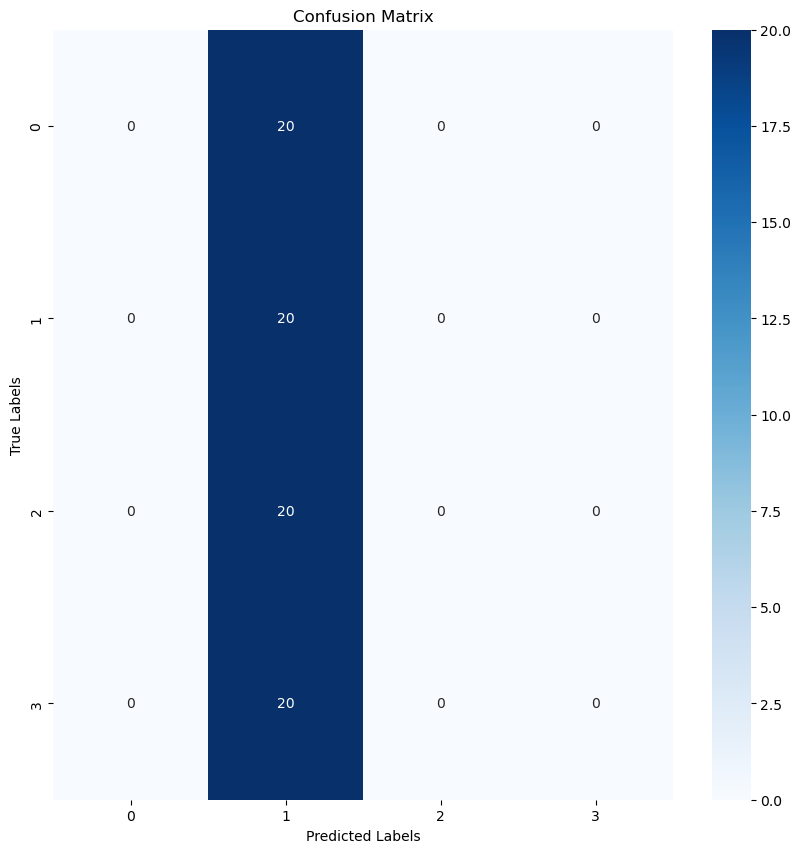

In [8]:
import torch
from sklearn.metrics import confusion_matrix, accuracy_score
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

# Function to evaluate the model
def evaluate_model(model, dataloader, device):
    model.eval()  # Set the model to evaluation mode
    all_predictions = []
    all_targets = []

    with torch.no_grad():
        for inputs, targets in dataloader:
            inputs = inputs.to(device)  # [batch_size, sequence_length, d_model]
            inputs = inputs.permute(1, 0, 2)  # Permute to match the model's expected input format
            targets = targets.to(device)
            outputs = model(inputs)
            _, predicted = torch.max(outputs, 1)
            all_predictions.extend(predicted.cpu().numpy())
            all_targets.extend(targets.cpu().numpy())

    return all_targets, all_predictions

# Evaluate the model
targets, predictions = evaluate_model(model, test_dataloader, device)

# Calculate accuracy
accuracy = accuracy_score(targets, predictions)
print(f'Test Accuracy: {accuracy * 100:.2f}%')

### Generating and Plotting the Confusion Matrix

# Confusion matrix
conf_mat = confusion_matrix(targets, predictions)
fig, ax = plt.subplots(figsize=(10, 10))
sns.heatmap(conf_mat, annot=True, fmt='d', ax=ax, cmap='Blues')
ax.set_xlabel('Predicted Labels')
ax.set_ylabel('True Labels')
ax.set_title('Confusion Matrix')
plt.show()
